<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/SNT/show_attend_tell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive/


In [2]:
!7z x '/content/gdrive/My Drive/Colab Notebooks/flikr.zip' -o'/content/data/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Colab Notebooks/                                                   1 file, 2285754264 bytes (2180 MiB)

Extracting archive: /content/gdrive/My Drive/Colab Notebooks/flikr.zip
 25% 4096 Open              --
Path = /content/gdrive/My Drive/Colab Notebooks/flikr.zip
Type = zip
Physical Size = 2285754264

  0%      1% 118 - Flickr_Data/Flickr_Data/Images/1119015538_e8e796281e.jpg                                                                     1% 235 - Flickr

In [3]:
import argparse, json
from collections import Counter


def generate_json_data(split_path, data_path, max_captions_per_image, min_word_count):
    split = json.load(open(split_path, 'r'))
    word_count = Counter()

    train_img_paths = []
    train_caption_tokens = []
    validation_img_paths = []
    validation_caption_tokens = []

    max_length = 0
    for img in split['images']:
        caption_count = 0
        for sentence in img['sentences']:
            if caption_count < max_captions_per_image:
                caption_count += 1
            else:
                break

            if img['split'] == 'train':
            
                train_img_paths.append(data_path + '/Images'  + '/' + img['filename'])
                train_caption_tokens.append(sentence['tokens'])
            elif img['split'] == 'val':
                validation_img_paths.append(data_path + '/Images' + '/' + img['filename'])
                validation_caption_tokens.append(sentence['tokens'])
            max_length = max(max_length, len(sentence['tokens']))
            word_count.update(sentence['tokens'])

    words = [word for word in word_count.keys() if word_count[word] >= min_word_count]
    word_dict = {word: idx + 4 for idx, word in enumerate(words)}
    word_dict['<start>'] = 0
    word_dict['<eos>'] = 1
    word_dict['<unk>'] = 2
    word_dict['<pad>'] = 3

    with open(data_path + '/word_dict.json', 'w') as f:
        json.dump(word_dict, f)

    train_captions = process_caption_tokens(train_caption_tokens, word_dict, max_length)
    validation_captions = process_caption_tokens(validation_caption_tokens, word_dict, max_length)

    with open(data_path + '/train_img_paths.json', 'w') as f:
        json.dump(train_img_paths, f)
    with open(data_path + '/val_img_paths.json', 'w') as f:
        json.dump(validation_img_paths, f)
    with open(data_path + '/train_captions.json', 'w') as f:
        json.dump(train_captions, f)
    with open(data_path + '/val_captions.json', 'w') as f:
        json.dump(validation_captions, f)


def process_caption_tokens(caption_tokens, word_dict, max_length):
    captions = []
    for tokens in caption_tokens:
        token_idxs = [word_dict[token] if token in word_dict else word_dict['<unk>'] for token in tokens]
        captions.append(
            [word_dict['<start>']] + token_idxs + [word_dict['<eos>']] +
            [word_dict['<pad>']] * (max_length - len(tokens)))

    return captions



generate_json_data('dataset.json','/content/data/flickr_data/Flickr_Data',2,5)

In [4]:
import json, os
import torch
from collections import Counter
from PIL import Image
from torch.utils.data import Dataset


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class ImageCaptionDataset(Dataset):
    def __init__(self, transform, data_path, split_type='train'):
        super(ImageCaptionDataset, self).__init__()
        self.split_type = split_type
        self.transform = transform

        self.word_count = Counter()
        self.caption_img_idx = {}
        self.img_paths = json.load(open(data_path + '/{}_img_paths.json'.format(split_type), 'r'))
        self.captions = json.load(open(data_path + '/{}_captions.json'.format(split_type), 'r'))

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = pil_loader(img_path)
        if self.transform is not None:
            img = self.transform(img)

        if self.split_type == 'train':
            return torch.FloatTensor(img), torch.tensor(self.captions[index])

        matching_idxs = [idx for idx, path in enumerate(self.img_paths) if path == img_path]
        all_captions = [self.captions[idx] for idx in matching_idxs]
        return torch.FloatTensor(img), torch.tensor(self.captions[index]), torch.tensor(all_captions)

    def __len__(self):
        return len(self.captions)

In [5]:
import torch.nn as nn
from torchvision.models import densenet161, resnet152, vgg19


class Encoder(nn.Module):
    def __init__(self, network='vgg19'):
        super(Encoder, self).__init__()
        self.network = network
        if network == 'resnet152':
            self.net = resnet152(pretrained=True)
            self.net = nn.Sequential(*list(self.net.children())[:-2])
            self.dim = 2048
        elif network == 'densenet161':
            self.net = densenet161(pretrained=True)
            self.net = nn.Sequential(*list(list(self.net.children())[0])[:-1])
            self.dim = 1920
        else:
            self.net = vgg19(pretrained=True)
            self.net = nn.Sequential(*list(self.net.features.children())[:-1])
            self.dim = 512

    def forward(self, x):
        x = self.net(x)
        x = x.permute(0, 2, 3, 1)
        x = x.view(x.size(0), -1, x.size(-1))
        return x

In [6]:
import torch
import torch.nn as nn



class Decoder(nn.Module):
    def __init__(self, vocabulary_size, encoder_dim, tf=False):
        super(Decoder, self).__init__()
        self.use_tf = tf

        self.vocabulary_size = vocabulary_size
        self.encoder_dim = encoder_dim

        self.init_h = nn.Linear(encoder_dim, 512)
        self.init_c = nn.Linear(encoder_dim, 512)
        self.tanh = nn.Tanh()

        self.f_beta = nn.Linear(512, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.deep_output = nn.Linear(512, vocabulary_size)
        self.dropout = nn.Dropout()

        self.attention = Attention(encoder_dim)
        self.embedding = nn.Embedding(vocabulary_size, 512)
        self.lstm = nn.LSTMCell(512 + encoder_dim, 512)

    def forward(self, img_features, captions):
        """
        We can use teacher forcing during training. For reference, refer to
        https://www.deeplearningbook.org/contents/rnn.html
        """
        batch_size = img_features.size(0)

        h, c = self.get_init_lstm_state(img_features)
        max_timespan = max([len(caption) for caption in captions]) - 1

        prev_words = torch.zeros(batch_size, 1).long().cuda()
        if self.use_tf:
            embedding = self.embedding(captions) if self.training else self.embedding(prev_words)
        else:
            embedding = self.embedding(prev_words)

        preds = torch.zeros(batch_size, max_timespan, self.vocabulary_size).cuda()
        alphas = torch.zeros(batch_size, max_timespan, img_features.size(1)).cuda()
        for t in range(max_timespan):
            context, alpha = self.attention(img_features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            if self.use_tf and self.training:
                lstm_input = torch.cat((embedding[:, t], gated_context), dim=1)
            else:
                embedding = embedding.squeeze(1) if embedding.dim() == 3 else embedding
                lstm_input = torch.cat((embedding, gated_context), dim=1)

            h, c = self.lstm(lstm_input, (h, c))
            output = self.deep_output(self.dropout(h))

            preds[:, t] = output
            alphas[:, t] = alpha

            if not self.training or not self.use_tf:
                embedding = self.embedding(output.max(1)[1].reshape(batch_size, 1))
        return preds, alphas

    def get_init_lstm_state(self, img_features):
        avg_features = img_features.mean(dim=1)

        c = self.init_c(avg_features)
        c = self.tanh(c)

        h = self.init_h(avg_features)
        h = self.tanh(h)

        return h, c

    def caption(self, img_features, beam_size=3):
        """
        We use beam search to construct the best sentences following a
        similar implementation as the author in
        https://github.com/kelvinxu/arctic-captions/blob/master/generate_caps.py
        """
        prev_words = torch.zeros(beam_size, 1).long()

        sentences = prev_words
        top_preds = torch.zeros(beam_size, 1)
        alphas = torch.ones(beam_size, 1, img_features.size(1))

        completed_sentences = []
        completed_sentences_alphas = []
        completed_sentences_preds = []

        step = 1
        h, c = self.get_init_lstm_state(img_features)

        while True:
            embedding = self.embedding(prev_words).squeeze(1)
            context, alpha = self.attention(img_features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context
            
            lstm_input = torch.cat((embedding, gated_context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.deep_output(h)
            output = top_preds.expand_as(output) + output

            if step == 1:
                top_preds, top_words = output[0].topk(beam_size, 0, True, True)
            else:
                top_preds, top_words = output.view(-1).topk(beam_size, 0, True, True)
            prev_word_idxs = top_words / output.size(1)
            next_word_idxs = top_words % output.size(1)
           
            prev_word_idxs=prev_word_idxs.type(torch.LongTensor)
            sentences = torch.cat((sentences[prev_word_idxs], next_word_idxs.unsqueeze(1)), dim=1)
            alphas = torch.cat((alphas[prev_word_idxs], alpha[prev_word_idxs].unsqueeze(1)), dim=1)

            incomplete = [idx for idx, next_word in enumerate(next_word_idxs) if next_word != 1]
            complete = list(set(range(len(next_word_idxs))) - set(incomplete))
           
            if len(complete) > 0:
                completed_sentences.extend(sentences[complete].tolist())
                completed_sentences_alphas.extend(alphas[complete].tolist())
                completed_sentences_preds.extend(top_preds[complete])
            beam_size -= len(complete)

            if beam_size == 0:
                break
            sentences = sentences[incomplete]
            alphas = alphas[incomplete]
            h = h[prev_word_idxs[incomplete]]
            c = c[prev_word_idxs[incomplete]]
            img_features = img_features[prev_word_idxs[incomplete]]
            top_preds = top_preds[incomplete].unsqueeze(1)
            prev_words = next_word_idxs[incomplete].unsqueeze(1)

            if step > 50:
                break
            step += 1
        
        idx = completed_sentences_preds.index(max(completed_sentences_preds))
        sentence = completed_sentences[idx]
        alpha = completed_sentences_alphas[idx]
        return sentence, alpha

In [7]:
import torch
import torch.nn as nn


class Attention(nn.Module):
    def __init__(self, encoder_dim):
        super(Attention, self).__init__()
        self.U = nn.Linear(512, 512)
        self.W = nn.Linear(encoder_dim, 512)
        self.v = nn.Linear(512, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, img_features, hidden_state):
        U_h = self.U(hidden_state).unsqueeze(1)
        W_s = self.W(img_features)
        att = self.tanh(W_s + U_h)
        e = self.v(att).squeeze(2)
        alpha = self.softmax(e)
        context = (img_features * alpha.unsqueeze(2)).sum(1)
        return context, alpha

In [8]:
import torch


class AverageMeter(object):
    """Taken from https://github.com/pytorch/examples/blob/master/imagenet/main.py"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(preds, targets, k):
    batch_size = targets.size(0)
    _, pred = preds.topk(k, 1, True, True)
    correct = pred.eq(targets.view(-1, 1).expand_as(pred))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() * (100.0 / batch_size)


def calculate_caption_lengths(word_dict, captions):
    lengths = 0
    for caption_tokens in captions:
        for token in caption_tokens:
            if token in (word_dict['<start>'], word_dict['<eos>'], word_dict['<pad>']):
                continue
            else:
                lengths += 1
    return lengths

In [9]:
def train(epoch, encoder, decoder, optimizer, cross_entropy_loss, data_loader, word_dict, writer, alpha_c=5, log_interval=50):
    encoder.eval()
    decoder.train()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    for batch_idx, (imgs, captions) in enumerate(data_loader):
        imgs, captions = Variable(imgs).cuda(), Variable(captions).cuda()
        img_features = encoder(imgs)
        optimizer.zero_grad()
        preds, alphas = decoder(img_features, captions)
        targets = captions[:, 1:]

        targets = pack_padded_sequence(targets, [len(tar) - 1 for tar in targets], batch_first=True)[0]
        preds = pack_padded_sequence(preds, [len(pred) - 1 for pred in preds], batch_first=True)[0]

        att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()

        loss = cross_entropy_loss(preds, targets)
        loss += att_regularization
        loss.backward()
        optimizer.step()

        total_caption_length = calculate_caption_lengths(word_dict, captions)
        acc1 = accuracy(preds, targets, 1)
        acc5 = accuracy(preds, targets, 5)
        losses.update(loss.item(), total_caption_length)
        top1.update(acc1, total_caption_length)
        top5.update(acc5, total_caption_length)

        if batch_idx % log_interval == 0:
            print('Train Batch: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top 1 Accuracy {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Top 5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(
                      batch_idx, len(data_loader), loss=losses, top1=top1, top5=top5))
    writer.add_scalar('train_loss', losses.avg, epoch)
    writer.add_scalar('train_top1_acc', top1.avg, epoch)
    writer.add_scalar('train_top5_acc', top5.avg, epoch)


def validate(epoch, encoder, decoder, cross_entropy_loss, data_loader, word_dict, writer, alpha_c=5, log_interval=50):
    encoder.eval()
    decoder.eval()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # used for calculating bleu scores
    references = []
    hypotheses = []
    with torch.no_grad():
        for batch_idx, (imgs, captions, all_captions) in enumerate(data_loader):
            imgs, captions = Variable(imgs).cuda(), Variable(captions).cuda()
            img_features = encoder(imgs)
            preds, alphas = decoder(img_features, captions)
            targets = captions[:, 1:]

            targets = pack_padded_sequence(targets, [len(tar) - 1 for tar in targets], batch_first=True)[0]
            packed_preds = pack_padded_sequence(preds, [len(pred) - 1 for pred in preds], batch_first=True)[0]

            att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()

            loss = cross_entropy_loss(packed_preds, targets)
            loss += att_regularization

            total_caption_length = calculate_caption_lengths(word_dict, captions)
            acc1 = accuracy(packed_preds, targets, 1)
            acc5 = accuracy(packed_preds, targets, 5)
            losses.update(loss.item(), total_caption_length)
            top1.update(acc1, total_caption_length)
            top5.update(acc5, total_caption_length)

            for cap_set in all_captions.tolist():
                caps = []
                for caption in cap_set:
                    cap = [word_idx for word_idx in caption
                                    if word_idx != word_dict['<start>'] and word_idx != word_dict['<pad>']]
                    caps.append(cap)
                references.append(caps)

            word_idxs = torch.max(preds, dim=2)[1]
            for idxs in word_idxs.tolist():
                hypotheses.append([idx for idx in idxs
                                       if idx != word_dict['<start>'] and idx != word_dict['<pad>']])

            if batch_idx % log_interval == 0:
                print('Validation Batch: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top 1 Accuracy {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Top 5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(
                          batch_idx, len(data_loader), loss=losses, top1=top1, top5=top5))
        writer.add_scalar('val_loss', losses.avg, epoch)
        writer.add_scalar('val_top1_acc', top1.avg, epoch)
        writer.add_scalar('val_top5_acc', top5.avg, epoch)

        bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(references, hypotheses)

        writer.add_scalar('val_bleu1', bleu_1, epoch)
        writer.add_scalar('val_bleu2', bleu_2, epoch)
        writer.add_scalar('val_bleu3', bleu_3, epoch)
        writer.add_scalar('val_bleu4', bleu_4, epoch)
        print('Validation Epoch: {}\t'
              'BLEU-1 ({})\t'
              'BLEU-2 ({})\t'
              'BLEU-3 ({})\t'
              'BLEU-4 ({})\t'.format(epoch, bleu_1, bleu_2, bleu_3, bleu_4))


In [ ]:
import argparse, json
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.translate.bleu_score import corpus_bleu
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

#from dataset import ImageCaptionDataset
#from decoder import Decoder
#from encoder import Encoder
#from utils import AverageMeter, accuracy, calculate_caption_lengths


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
   # transforms.Normalize(mean=[0.485, 0.456, 0.406],
   #                      std=[0.229, 0.224, 0.225])
])

writer = SummaryWriter()

word_dict = json.load(open('/content/data/flickr_data/Flickr_Data' + '/word_dict.json', 'r'))
vocabulary_size = len(word_dict)

encoder = Encoder(network='vgg19')
decoder = Decoder(vocabulary_size, encoder.dim,tf=False)

#if model:
#    decoder.load_state_dict(torch.load(model))

encoder.cuda()
decoder.cuda()

optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)
cross_entropy_loss = nn.CrossEntropyLoss().cuda()

train_loader = torch.utils.data.DataLoader(
ImageCaptionDataset(data_transforms,data_path='/content/data/flickr_data/Flickr_Data'),
        batch_size=64, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
ImageCaptionDataset(data_transforms,data_path='/content/data/flickr_data/Flickr_Data', split_type='val'),
        batch_size=64, shuffle=True, num_workers=1)

#print('Starting training with {}'.format(args))
epochs=10
alpha_c=5
log_interval=50
for epoch in range(1, epochs + 1):
        scheduler.step()
        train(epoch,encoder, decoder, optimizer, cross_entropy_loss,train_loader, word_dict, writer, alpha_c,log_interval)
        validate(epoch, encoder, decoder, cross_entropy_loss, val_loader,word_dict,writer, alpha_c,log_interval)
        model_file = '/content/gdrive/My Drive/Colab Notebooks/'+'model' + '_' + str(epoch) + '.pth'
        torch.save(decoder.state_dict(), model_file)
        print('Saved model to ' + model_file)
writer.close()



    

In [11]:
import argparse, json, os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.transform
import torch
import torchvision.transforms as transforms
from math import ceil
from PIL import Image



def generate_caption_visualization(encoder, decoder, word_dict,img_path, beam_size=3, smooth=True):
    img = pil_loader(img_path)
    img = data_transforms(img)
    img = torch.FloatTensor(img)
    img = img.unsqueeze(0)

    img_features = encoder(img)
    img_features = img_features.expand(beam_size, img_features.size(1), img_features.size(2))

    sentence, alpha = decoder.caption(img_features, beam_size)
    

    token_dict = {idx: word for word, idx in word_dict.items()}
    sentence_tokens = []
    for word_idx in sentence:
        sentence_tokens.append(token_dict[word_idx])
        if word_idx == word_dict['<eos>']:
            break

    img = Image.open(img_path)
    w, h = img.size
    if w > h:
        w = w * 256 / h
        h = 256
    else:
        h = h * 256 / w
        w = 256
    left = (w - 224) / 2
    top = (h - 224) / 2
    resized_img = img.resize((int(w), int(h)), Image.BICUBIC).crop((left, top, left + 224, top + 224))
    img = np.array(resized_img.convert('RGB').getdata()).reshape(224, 224, 3)
    img = img.astype('float32') / 255

    num_words = len(sentence_tokens)
    w = np.round(np.sqrt(num_words))
    h = np.ceil(np.float32(num_words) / w)
    alpha = torch.tensor(alpha)

    plot_height = ceil((num_words + 3) / 4.0)
    ax1 = plt.subplot(4, plot_height, 1)
    plt.imshow(img)
    plt.axis('off')
    for idx in range(num_words):
        ax2 = plt.subplot(4, plot_height, idx + 2)
        label = sentence_tokens[idx]
        plt.text(0, 1, label, backgroundcolor='white', fontsize=13)
        plt.text(0, 1, label, color='black', fontsize=13)
        plt.imshow(img)

        if encoder.network == 'vgg19':
            shape_size = 14
        else:
            shape_size = 7

        if smooth:
            alpha_img = skimage.transform.pyramid_expand(alpha[idx, :].reshape(shape_size, shape_size), upscale=16, sigma=20)
        else:
            alpha_img = skimage.transform.resize(alpha[idx, :].reshape(shape_size,shape_size), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()
    

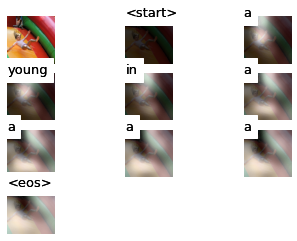

In [15]:
word_dict = json.load(open('/content/data/flickr_data/Flickr_Data' + '/word_dict.json', 'r'))
vocabulary_size = len(word_dict)
encoder = Encoder(network='vgg19')
decoder = Decoder(vocabulary_size, encoder.dim)

decoder.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/model_10.pth'))

    # encoder.cuda()
    # decoder.cuda()

encoder.eval()
decoder.eval()

generate_caption_visualization(encoder, decoder, word_dict,img_path='/content/data/flickr_data/Flickr_Data/Images/1443807993_aebfb2784a.jpg')